In [1]:
%matplotlib inline

In [2]:
# Copyright (c) 2015,2018,2019 MetPy Developers.
# Distributed under the terms of the BSD 3-Clause License.
# SPDX-License-Identifier: BSD-3-Clause

# NEXRAD Level 2 File

Use MetPy to read information from a NEXRAD Level 2 (volume) file and plot

In [3]:
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

from metpy.calc import azimuth_range_to_lat_lon
from metpy.cbook import get_test_data
from metpy.io import Level2File
from metpy.plots import add_metpy_logo, add_timestamp, USCOUNTIES
from metpy.units import units

Open the file

In [4]:
name = get_test_data('KTLX20130520_201643_V06.gz', as_file_obj=False)
f = Level2File(name)

print(f.sweeps[0][0])

Radial(header=Msg31DataHdr(stid=b'KTLX', time_ms=73003850, date=15846, az_num=1, az_angle=123.20343017578125, compression=0, rad_length=6856, az_spacing=0.5, rad_status=5, el_num=1, sector_num=1, el_angle=0.5987548828125, spot_blanking=None, az_index_mode=0.25, num_data_blks=7), vol_consts=VolConsts(type=b'R', name=b'VOL', size=44, major=1, minor=0, lat=35.33305740356445, lon=-97.27748107910156, site_amsl=369, feedhorn_agl=19, calib_dbz=-43.72919845581055, txpower_h=185.05685424804688, txpower_v=181.45559692382812, sys_zdr=-0.08510557562112808, phidp0=25.0, vcp=12, processing_status=None), elev_consts=ElConsts(type=b'R', name=b'ELV', size=12, atmos_atten=-0.012, calib_dbz0=-42.4375), radial_consts=RadConstsV1(type=b'R', name=b'RAD', size=20, unamb_range=466.0, noise_h=-79.71426391601562, noise_v=-79.39848327636719, nyq_vel=8.3), moments={b'REF': (DataBlockHdr(type=b'D', name=b'REF', reserved=0, num_gates=1832, first_gate=2.125, gate_width=0.25, tover=5.0, snr_thresh=1.6, recombined=Non

In [5]:
# Pull data out of the file
sweep = 0

# First item in ray is header, which has azimuth angle
az = np.array([ray[0].az_angle for ray in f.sweeps[sweep]])

We need to take the single azimuth (nominally a mid-point) we get in the data and
convert it to be the azimuth of the boundary between rays of data, taking care to handle
where the azimuth crosses from 0 to 360.

In [6]:
diff = np.diff(az)
crossed = diff < -180
diff[crossed] += 360.
avg_spacing = diff.mean()

# Convert mid-point to edge
az = (az[:-1] + az[1:]) / 2
az[crossed] += 180.

# Concatenate with overall start and end of data we calculate using the average spacing
az = np.concatenate(([az[0] - avg_spacing], az, [az[-1] + avg_spacing]))
az = units.Quantity(az, 'degrees')

Calculate ranges for the gates from the metadata

In [7]:
# 5th item is a dict mapping a var name (byte string) to a tuple
# of (header, data array)
ref_hdr = f.sweeps[sweep][0][4][b'REF'][0]
ref_range = (np.arange(ref_hdr.num_gates + 1) - 0.5) * ref_hdr.gate_width + ref_hdr.first_gate
ref_range = units.Quantity(ref_range, 'kilometers')
ref = np.array([ray[4][b'REF'][1] for ray in f.sweeps[sweep]])

rho_hdr = f.sweeps[sweep][0][4][b'RHO'][0]
rho_range = (np.arange(rho_hdr.num_gates + 1) - 0.5) * rho_hdr.gate_width + rho_hdr.first_gate
rho_range = units.Quantity(rho_range, 'kilometers')
rho = np.array([ray[4][b'RHO'][1] for ray in f.sweeps[sweep]])

# Extract central longitude and latitude from file
cent_lon = f.sweeps[0][0][1].lon
cent_lat = f.sweeps[0][0][1].lat

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


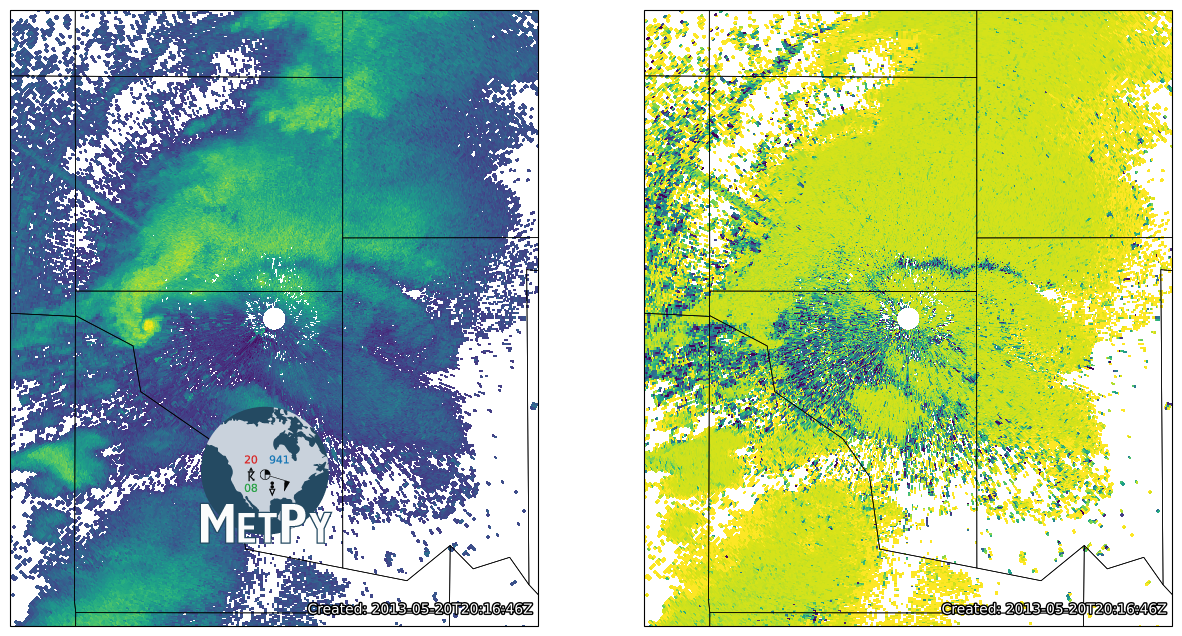

In [8]:
spec = gridspec.GridSpec(1, 2)
fig = plt.figure(figsize=(15, 8))
add_metpy_logo(fig, 190, 85, size='large')

for var_data, var_range, ax_rect in zip((ref, rho), (ref_range, rho_range), spec,
                                        strict=False):
    # Turn into an array, then mask
    data = np.ma.array(var_data)
    data[np.isnan(data)] = np.ma.masked

    # Convert az,range to x,y
    xlocs, ylocs = azimuth_range_to_lat_lon(az, var_range, cent_lon, cent_lat)

    # Plot the data
    crs = ccrs.LambertConformal(central_longitude=cent_lon, central_latitude=cent_lat)
    ax = fig.add_subplot(ax_rect, projection=crs)
    ax.add_feature(USCOUNTIES, linewidth=0.5)
    ax.pcolormesh(xlocs, ylocs, data, cmap='viridis', transform=ccrs.PlateCarree())
    ax.set_extent([cent_lon - 0.5, cent_lon + 0.5, cent_lat - 0.5, cent_lat + 0.5])
    ax.set_aspect('equal', 'datalim')
    add_timestamp(ax, f.dt, y=0.02, high_contrast=True)

plt.show()